**LAYERWISE ANALYSIS OF CROSS MODEL ATTENTION PATTERNS IN VISION LANGUAGE MODEL FOR VISUAL QUESTION AND ANSWERING**





Name : ***GUNDALA JAIKRISHNA REDDY***

Student Id:  ***24131989***

 Importing Libraries

In [ ]:
import os
import re
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViltProcessor, ViltForQuestionAnswering
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from google.colab import files
from collections import Counter
warnings.filterwarnings("ignore")


Path setup and defining dataset

In [ ]:

QUESTIONS_JSON_PATH = "/content/drive/MyDrive/Final_sem/dataset/v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json"
ANNOTATIONS_JSON_PATH = "/content/drive/MyDrive/Final_sem/dataset/v2_mscoco_val2014_annotations.json"
IMAGES_ROOT = "/content/drive/MyDrive/Final_sem/dataset/val2014"
OUTPUT_DIR = "/content/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


Loading questions and annotations

In [ ]:
# Loading json questions
with open(QUESTIONS_JSON_PATH, "r") as f:
    questions_data = json.load(f)
q_df = pd.DataFrame(questions_data["questions"])[["question_id", "image_id", "question"]]

# Loading json annotations
with open(ANNOTATIONS_JSON_PATH, "r") as f:
    ann_data = json.load(f)
ann_df = pd.DataFrame(ann_data["annotations"])[["question_id", "answers"]]

# Merge and filtering dataset
df = q_df.merge(ann_df, on="question_id", how="inner")

def guess_coco_filename(image_id, split="val2014"):
    return [f"COCO_{split}_{image_id:012d}.jpg", f"COCO_{split}_{image_id:06d}.jpg"]

all_images = {os.path.basename(p): p for p in Path(IMAGES_ROOT).rglob("*.jpg")}

def find_image_path(img_id):
    for fn in guess_coco_filename(img_id):
        if fn in all_images:
            return all_images[fn]
    return None

df["image_path"] = df["image_id"].apply(find_image_path)
df = df.dropna(subset=["image_path"]).reset_index(drop=True)

print(f"✅ Usable samples (Total Q&A pairs): {len(df)}")
print(f"🖼️  Unique images: {df['image_id'].nunique()}")


✅ Usable samples (Total Q&A pairs): 113489
🖼️  Unique images: 21324


Question Type Categorization

In [ ]:
#classfying questions into different types:
def qtype(q):
    ql = q.lower().strip()
    if ql.startswith(("is", "are", "was", "were", "do", "does", "did", "can", "could", "will", "would", "has", "have", "had")):
        return "yes/no"
    if "how many" in ql or "number" in ql or "count" in ql:
        return "number"
    if ql.startswith(("where",)): return "where"
    if ql.startswith(("why",)): return "why"
    if ql.startswith(("who",)): return "who"
    if ql.startswith(("what",)): return "what"
    if ql.startswith(("how",)): return "how"
    if ql.startswith(("which",)): return "which"
    if ql.startswith(("when",)): return "when"
    return "other"

df["qtype"] = df["question"].apply(qtype)


Building the VQA Dataset and Evaluating Answers

In [ ]:
class VQALocalDataset(Dataset):
    def __init__(self, frame):
        self.df = frame.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        return {
            "image": img,
            "image_id": int(row["image_id"]),
            "image_path": row["image_path"],
            "question": row["question"],
            "answers": [a["answer"] for a in row["answers"]],
            "question_id": int(row["question_id"]),
            "qtype": row["qtype"]
        }
_ARTICLES = {"a", "an", "the"}
_PUNC_RE = re.compile(r"[!\"#$%&'()*+,-./:;<=>?@\[\\\]^_`{|}~]")
_SPACE_RE = re.compile(r"\s+")

def normalize(s):
    s = s.lower().strip()
    s = _PUNC_RE.sub(" ", s)
    s = _SPACE_RE.sub(" ", s)
    return " ".join([w for w in s.split() if w not in _ARTICLES])

def soft_score(pred, answers):
    if not answers:
        return 0.0
    n = sum(1 for a in answers if normalize(a) == normalize(pred))
    return min(1.0, n / 3.0)


🚀 Running ViLT Model and Collecting Results

In [ ]:
@torch.no_grad()
def run_vilt(df):
    print("⚙️ Evaluating with ViLT...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa").to(device).eval()
    processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
    model.config.id2label
    print(f"🔍 Total examples to process: {len(df)}")
    print("🧠 Loading ViLT model and processor...")
    print("✅ Model and processor loaded successfully.")
    print(f"📦 Device in use: {device}")
    print("Starting the batching process...")

    loader = DataLoader(VQALocalDataset(df), batch_size=16, shuffle=False, num_workers=2, collate_fn=lambda x: x)
    id2label = model.config.id2label

    results, text_to_image_layers, image_to_text_layers = [], [], []
    patch_size = getattr(model.config, "patch_size", 32)


    for batch in tqdm(loader, total=len(loader)):

        images    = [ex["image"] for ex in batch]
        questions = [ex["question"] for ex in batch]

        # Encoding batches
        enc = processor(images=images, text=questions, return_tensors="pt", padding=True, truncation=True)
        enc = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in enc.items()}

        out = model(**enc, output_attentions=True, return_dict=True)

        preds = out.logits.argmax(-1).cpu().tolist()
        pred_answers = [id2label[int(i)] for i in preds]

        input_ids, pixel_values = enc["input_ids"], enc["pixel_values"]
        attention_mask, pixel_mask = enc["attention_mask"], enc.get("pixel_mask", None)
        token_type_ids = enc.get("token_type_ids", None)

        layer_list = out.attentions
        S_total = layer_list[0].shape[-1]
        pad_id = processor.tokenizer.pad_token_id
        B = input_ids.size(0)

        for bi in range(B):
            ex = batch[bi]
            pa = pred_answers[bi]

            # Collecting prediction
            results.append({
                "question_id": ex["question_id"],
                "image_id": ex["image_id"],
                "question": ex["question"],
                "qtype": ex["qtype"],
                "predicted_answer": pa,
                "answers": ex["answers"],
                "soft_acc": soft_score(pa, ex["answers"])
            })

            # Figure out token/image masks
            t_len = int((input_ids[bi] != pad_id).sum().item())
            if pixel_mask is not None:
                n_img = int(pixel_mask[bi].sum().item())
            else:
                Hres, Wres = int(pixel_values[bi].shape[-2]), int(pixel_values[bi].shape[-1])
                gy, gx = Hres // patch_size, Wres // patch_size
                n_img = int(gy * gx)

            if t_len + n_img > S_total:
                n_img = max(0, S_total - t_len)

            if token_type_ids is not None and (token_type_ids[bi] == 1).any() and token_type_ids.shape[-1] == S_total:
                tmask = (token_type_ids[bi] == 0)
                imask = (token_type_ids[bi] == 1)
            else:
                tmask = torch.zeros(S_total, dtype=torch.bool, device=device)
                imask = torch.zeros(S_total, dtype=torch.bool, device=device)
                t_end = min(t_len, S_total)
                tmask[:t_end] = True
                i_end = min(t_end + n_img, S_total)
                imask[t_end:i_end] = True

            # Collecting attention scores
            t2i_per_layer, i2t_per_layer = [], []
            for a in layer_list:
                att_b = a[bi]
                t2i = att_b[:, tmask][:, :, imask].mean(dim=(1, 2)).cpu().numpy()
                i2t = att_b[:, imask][:, :, tmask].mean(dim=(1, 2)).cpu().numpy()
                t2i_per_layer.append(t2i)
                i2t_per_layer.append(i2t)

            text_to_image_layers.append(np.vstack(t2i_per_layer))
            image_to_text_layers.append(np.vstack(i2t_per_layer))


    return results, text_to_image_layers, image_to_text_layers
print("Batching process completed. Model inference is finished.")
# Run inference
results, text_to_image_layers, image_to_text_layers = run_vilt(df)
preds_df = pd.DataFrame(results)
qtypes_list = df["qtype"].tolist()


Batching process completed. Model inference is finished.
⚙️ Evaluating with ViLT...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/470M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

🔍 Total examples to process: 113489
🧠 Loading ViLT model and processor...
✅ Model and processor loaded successfully.
📦 Device in use: cuda
Starting the batching process...


100%|██████████| 7094/7094 [57:47<00:00,  2.05it/s]


Accuracy Evaluation

In [ ]:
# Overall accuracy
overall_acc = preds_df["soft_acc"].mean()
correct_preds = (preds_df["soft_acc"] > 0).sum()
total_preds = len(preds_df)

print(f"\n✅ Overall accuracy: {overall_acc:.3f}")
print(f"✅ Correct predictions: {correct_preds}/{total_preds}")

# Accuracy by question type
per_type = preds_df.groupby("qtype")["soft_acc"].mean().reset_index()
per_type.columns = ["Question Type", "Accuracy"]
print("\n📊 Accuracy per question type:")
print(per_type)



✅ Overall accuracy: 0.829
✅ Correct predictions: 100922/113489

📊 Accuracy per question type:
  Question Type  Accuracy
0           how  0.538305
1        number  0.694135
2         other  0.754525
3          what  0.783214
4          when  0.566667
5         where  0.635330
6         which  0.672979
7           who  0.648033
8           why  0.481299
9        yes/no  0.954893


 Saving the Predictions

In [ ]:

preds_df.rename(columns={"answers": "top_10_answers"}, inplace=True)

# Save and download CSV
preds_df_to_save = preds_df.drop(columns=["soft_acc"])
pred_path = os.path.join(OUTPUT_DIR, "predictions_vqa.csv")
preds_df_to_save.to_csv(pred_path, index=False)
files.download(pred_path)
print(f"CSV saved to {pred_path}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CSV saved to /content/outputs/predictions_vqa.csv


📈 Plot Layer-wise Text→Image Attention (Per Layer)

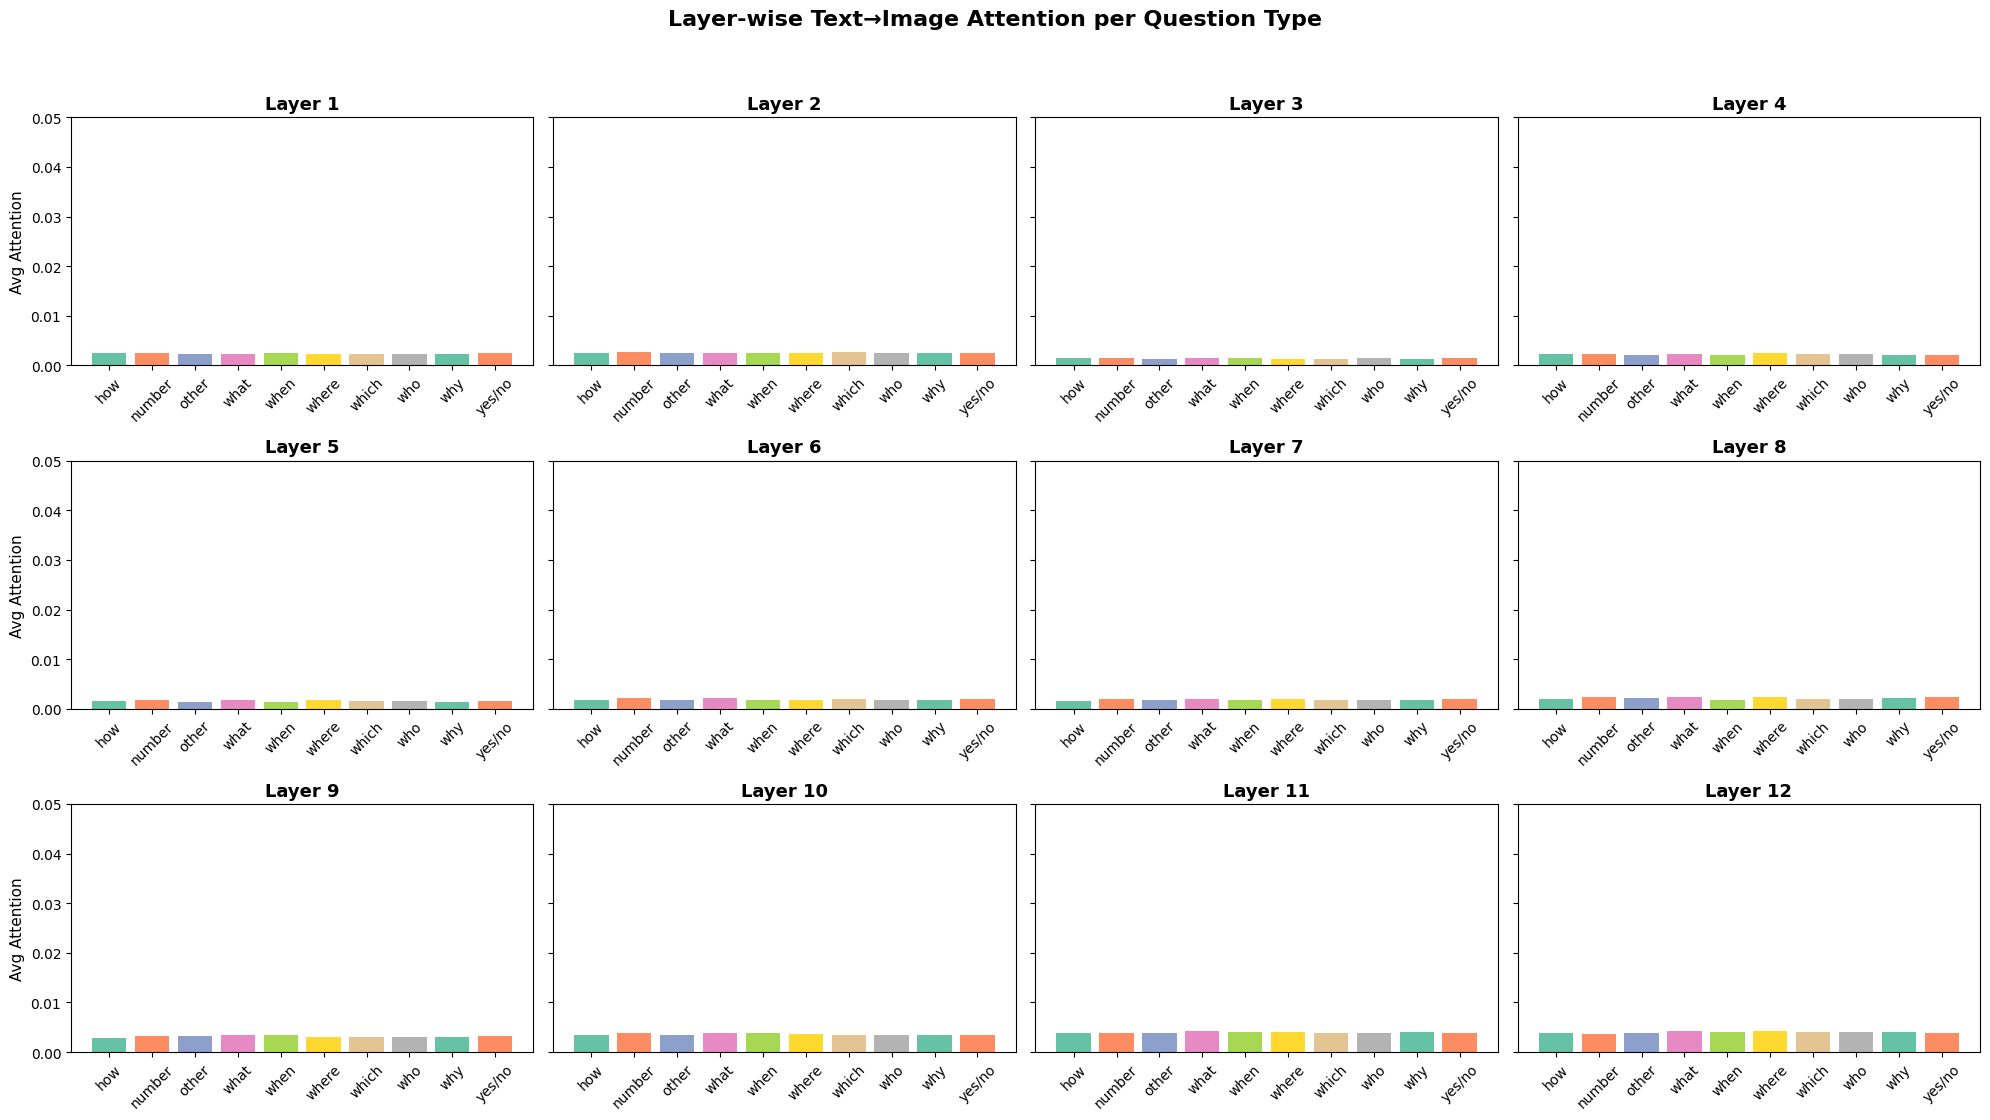

In [ ]:
data_records = []
for mat, qt in zip(text_to_image_layers, qtypes_list):
    layer_avgs = mat.mean(axis=1)
    for layer_idx, val in enumerate(layer_avgs):
        data_records.append({"qtype": qt, "layer": layer_idx + 1, "t2i_attention": float(val)})

df_attn = pd.DataFrame(data_records)
num_layers = df_attn["layer"].max()
qtypes = sorted(df_attn["qtype"].unique())
palette = sns.color_palette("Set2", n_colors=len(qtypes))

fig, axes = plt.subplots(3, 4, figsize=(20, 12), sharey=True)
axes = axes.flatten()

for i in range(num_layers):
    ax = axes[i]
    layer_data = df_attn[df_attn["layer"] == (i+1)]
    means = layer_data.groupby("qtype")["t2i_attention"].mean().reindex(qtypes)
    colors = [palette[qtypes.index(qt)] for qt in means.index]
    ax.bar(means.index, means.values, color=colors)
    ax.set_title(f"Layer {i+1}", fontsize=13, weight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.set_ylim(0, max(df_attn["t2i_attention"].max(), 0.05))
    if i % 4 == 0:
        ax.set_ylabel("Avg Attention", fontsize=11)

fig.suptitle("Layer-wise Text→Image Attention per Question Type", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


🔝 Top-20 Predicted Answers

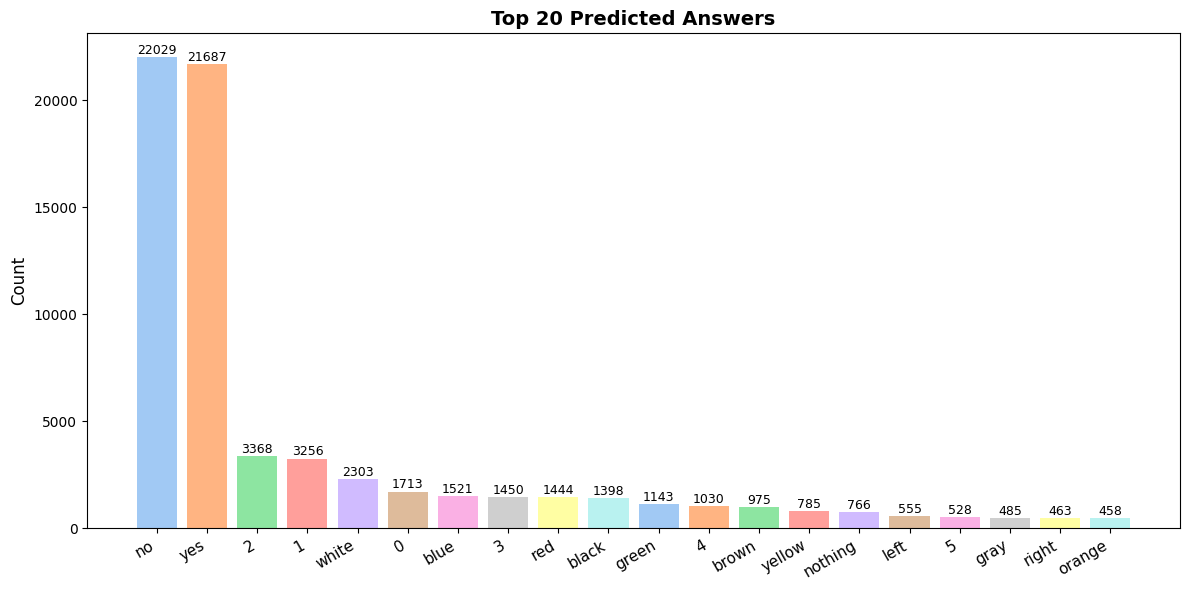

In [ ]:
top_preds = preds_df["predicted_answer"]
top_counts = Counter(top_preds)
top_20 = top_counts.most_common(20)
labels, values = zip(*top_20)

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color=sns.color_palette("pastel", len(labels)))
plt.xticks(rotation=30, ha="right", fontsize=11)
plt.title("Top 20 Predicted Answers", fontsize=14, weight="bold")
plt.ylabel("Count", fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



📈 Average Attention by Question Type

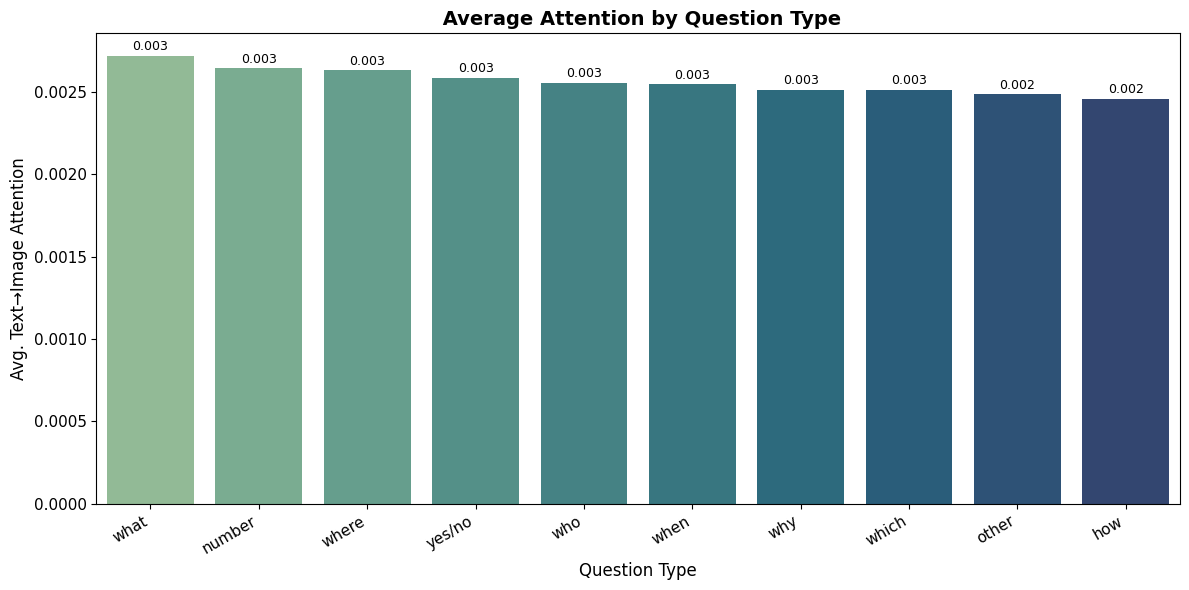

In [ ]:
mean_att_per_qtype = df_attn.groupby("qtype")["t2i_attention"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
bars = sns.barplot(
    x=mean_att_per_qtype.index,
    y=mean_att_per_qtype.values,
    palette="crest"
)

plt.xticks(rotation=30, ha="right", fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Question Type", fontsize=12)
plt.ylabel("Avg. Text→Image Attention", fontsize=12)
plt.title(" Average Attention by Question Type", fontsize=14, weight="bold")

# Add labels neatly on top of bars
for container in bars.containers:
    bars.bar_label(container, fmt="%.3f", fontsize=9, label_type="edge", padding=2)

plt.tight_layout()
plt.show()


🔥 Heatmap: Attention Across Layers × Question Types

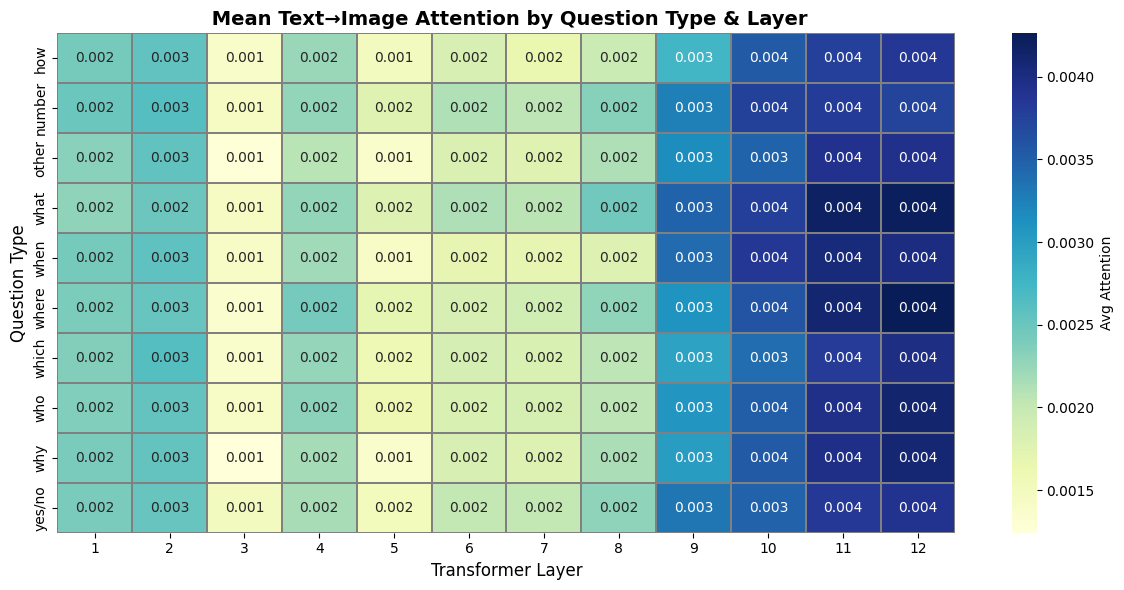

In [ ]:
heatmap_data = df_attn.groupby(["qtype", "layer"])["t2i_attention"].mean().reset_index()
heatmap_pivot = heatmap_data.pivot(index="qtype", columns="layer", values="t2i_attention")

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_pivot, annot=True, fmt=".3f", cmap="YlGnBu",
    linewidths=0.3, linecolor='gray', cbar_kws={"label": "Avg Attention"}
)

plt.title(" Mean Text→Image Attention by Question Type & Layer", fontsize=14, weight='bold')
plt.xlabel("Transformer Layer", fontsize=12)
plt.ylabel("Question Type", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
